In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import keras

In [2]:
images = np.load('data/images.npy')
test = np.load('data/images_sub.npy')
labels = np.load('data/labels.npy')

images.shape, test.shape, labels.shape

((20000, 48, 48, 3), (50000, 48, 48, 3), (20000,))

In [3]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train = X_train.astype("float")
X_val = X_val.astype("float")
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((16000, 48, 48, 3), (16000,), (4000, 48, 48, 3), (4000,))

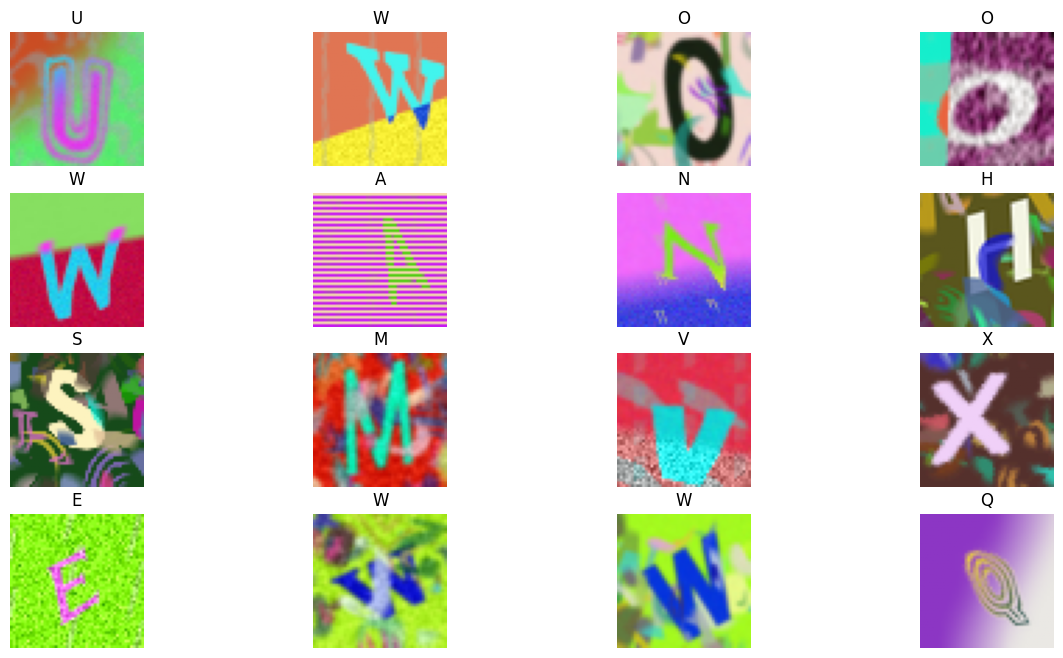

In [4]:
fig, ax = plt.subplots(4, 4, figsize=(15, 8))

for i in range(16):
    img = X_train[i]  / 255.0
    label = y_train[i]

    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(chr(ord('A') + label))
    ax[i // 4, i % 4].axis("off")

plt.show()

In [5]:
def prepare_model(shape):
    input_img = keras.Input(shape=shape, name="image")

    x = keras.layers.Rescaling(1./255)(input_img)
    x = keras.applications.EfficientNetV2L(weights="imagenet", include_top=False)(x)
    x = keras.layers.GlobalAveragePooling2D(name="pool")(x)
    x = keras.layers.Dense(512, activation='relu')(x)
    # There are 26 letters in the English alphabet
    output = keras.layers.Dense(26, activation='softmax', name="output")(x)

    model = keras.models.Model(inputs=input_img, outputs=output, name="capcha_recognizer")
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = prepare_model(X_train[0].shape)
model.summary()

Model: "capcha_recognizer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 2, 2, 1280)     │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool (GlobalAveragePooling2D)   │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 26)             │        13,338 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,416,058 (451.72 MB)

 Trainable params: 117,903,482 (449.77 MB)

 Non-trainable params: 512,576 (1.96 MB)

In [6]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

history = model.fit(
    X_train, y_train, epochs=75, validation_data=(X_val, y_val), verbose=1,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        ModelCheckpoint(monitor='val_loss', filepath='best_model.h5', save_best_only=True),
    ],
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 629s 1s/step - accuracy: 0.3593 - loss: 2.1261 - val_accuracy: 0.7525 - val_loss: 0.8137
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 615s 1s/step - accuracy: 0.8056 - loss: 0.6446 - val_accuracy: 0.8055 - val_loss: 0.7916
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 638s 1s/step - accuracy: 0.8915 - loss: 0.3699 - val_accuracy: 0.8188 - val_loss: 0.6568
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 621s 1s/step - accuracy: 0.9128 - loss: 0.2918 - val_accuracy: 0.8205 - val_loss: 0.6383
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 630s 1s/step - accuracy: 0.9339 - loss: 0.2224 - val_accuracy: 0.8662 - val_loss: 0.5394
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1863s 4s/step - accuracy: 0.9432 - loss: 0.1962 - val_accuracy: 0.8265 - val_loss: 0.5955
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2979s 6s/step - accuracy: 0.9579 - loss: 0.1573 - val_accuracy: 0.8205 - val_loss: 0.6743
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1824s 4s/step - accuracy: 0.9631 - loss: 0.1289 - val_a

In [7]:
predictions = model.predict(test)
predicted_labels = predictions.argmax(axis=1)

submission_df = pd.DataFrame({
    'Id': range(0, len(predicted_labels)),
    'Category': predicted_labels
})
submission_df

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 980s 624ms/step


,Id,Category
0,0,8
1,1,8
2,2,3
3,3,12
4,4,10
...,...,...
49995,49995,4
49996,49996,17
49997,49997,14
49998,49998,3


In [8]:
submission_df.to_csv("submission.csv", index=False)